In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from img_utils import *
path = "../nybolig-scrape/output/part_1"
# path = "../nybolig-scrape/output/part_2"
houses_df = data_to_DF_old(path, max_houses=1000)
display(houses_df.head())

2024-04-18 10:57:59.274035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 10:57:59.274110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 10:57:59.410479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 10:57:59.547844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 10:58:01.156127: W tensorflow/compiler/tf2

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
0,https://www.nybolig.dk/ejerlejlighed/1867/acac...,Acaciavej 1 1. 1867 Frederiksberg C,1867,ejerlejlighed,9995000,124,None,4.0,1875.0,2022.0,B,55.678522749037,12.5397212034588,0.00,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,https://www.nybolig.dk/ejerlejlighed/2610/ager...,Agerskovvej 4D 2. 2610 Rødovre,2610,ejerlejlighed,1945000,70,None,2.0,1968.0,NaN,D,56.5753563308919,8.2055979563106,33273.25,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,https://www.nybolig.dk/ejerlejlighed/2610/ager...,Agerskovvej 4M st. 2610 Rødovre,2610,ejerlejlighed,2195000,70,None,2.0,1968.0,NaN,D,56.5753563308919,8.2055979563106,33273.25,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,https://www.nybolig.dk/ejerlejlighed/2100/agge...,Aggersborggade 9 1. tv 2100 København Ø,2100,ejerlejlighed,5650000,80,None,3.0,1896.0,1933.0,D,55.6992221443005,12.5868488817465,55737.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,https://www.nybolig.dk/ejerlejlighed/2700/agge...,Aggersvoldvej 3B 3. 2700 Brønshøj,2700,ejerlejlighed,2725000,66,None,3.0,1934.0,NaN,C,55.6965483017383,12.5003343598185,33507.50,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [3]:
from utils import remove_outliers
from img_utils import preprocess_images

#Remove the outliers 
houses_df = remove_outliers(houses_df, 'price', z_score_threshold=2)

#Drop houses with no floorplan
houses_df = houses_df.dropna(subset=['image_floorplan'])

In [4]:
import numpy as np
import pandas as pd

# Drop "url" column
houses_df = houses_df.drop(columns=['url'])

# Set the basement_size to 0 if it is NaN
houses_df['basement_size'] = houses_df['basement_size'].fillna(0)

# Set the year_rebuilt to year_built if it is NaN
houses_df['year_rebuilt'] = houses_df['year_rebuilt'].fillna(houses_df['year_built'])

# Encode the features: postal_code, type, energy_class
houses_df['postal_code'] = houses_df['postal_code'].astype('category').cat.codes
houses_df['type'] = houses_df['type'].astype('category').cat.codes
houses_df['energy_label'] = houses_df['energy_label'].astype('category').cat.codes

# Drop NaN values
houses_df = houses_df.dropna()

In [5]:
from sklearn.model_selection import train_test_split
from utils import prepare_features
# houses_df = prepare_features(houses_df)
print("Number of Datapoints: ", len(houses_df))

# Drop rows with "longitude" or "latitude" set to 0
houses_before = len(houses_df)
houses_df = houses_df[(houses_df["lng"] != 0) & (houses_df["lat"] != 0)]

# Turn "lat" and "lng" to floats
houses_df["lat"] = houses_df["lat"].astype(float)
houses_df["lng"] = houses_df["lng"].astype(float)

# Print the number of datapoints removed
print(f"{houses_before - len(houses_df)} datapoints removed")
print("Number of Datapoints after removing 0 coordinates: ", len(houses_df))

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=0)
# train_df_unused, train_df = train_test_split(train_df, test_size=0.5, random_state=0)
train2_df, train1_df = train_test_split(train_df, test_size=0.5, random_state=0)

# Print first 5 entries of both train_df_unused and train_df
print("train2_df:")
print(train2_df.head())
print("train_1_df:")
print(train1_df.head())
print("test_df:")
print(test_df.head())

print("Number of training samples: ", len(train1_df))

# Print the __dict__ of the first entry in the train_df
print(train1_df.iloc[0].__dict__)

Number of Datapoints:  842
51 datapoints removed
Number of Datapoints after removing 0 coordinates:  791
train2_df:
                                         address  postal_code  type    price  \
584           Pilegårdsvej 34 2. tv. 2860 Søborg           99     0  1650000   
475  Lyngbygårdsvej 65 1. th 2800 Kongens Lyngby           94     0  2245000   
845   Vordingborggade 90 2. tv. 2100 København Ø           66     0  2795000   
95          Brogårdsvej 137 1. th. 2820 Gentofte           95     0  2995000   
689         Solrød Center 20B 2680 Solrød Strand           84     0  3095000   

     size  basement_size  rooms  year_built  year_rebuilt  energy_label  \
584    55              0    2.0      1966.0        1966.0             6   
475    53              0    2.0      1946.0        1955.0             4   
845    50              0    2.0      1935.0        1935.0             6   
95     85              0    4.0      1946.0        1946.0             6   
689   117              0    

# Feeding Vision Prediction into Random Forrest

In [6]:
# Find the top 10 values with highest error
def plot_worst_preds(
    y_test: np.ndarray, y_pred: np.ndarray, dataset: pd.DataFrame, n: int = 5
) -> None:
    """
    Find the top 5 values with highest error
    Locate them in the dataset.
    Foreach of the top 5 values
    """
    # Calculate residuals
    residuals: np.ndarray = y_test - y_pred
    # Calculate distances from the perfect fit line
    distances: np.ndarray = np.abs(residuals)
    # Find the top 5 values with highest error
    top_n_idx: np.ndarray = np.argsort(distances)[-n:]
    top_n_idx = top_n_idx[::-1]

    # Plot the top 5 values with highest error
    for idx in top_n_idx:
        print(
            "Predicted",
            y_pred[idx],
            "True",
            y_test[idx],
            "Residual",
            residuals[idx],
            "Distance",
            distances[idx],
        )
        # print(f"Address: {addresses.iloc[idx]}")
        top_i = dataset.iloc[idx]
        display(top_i.to_frame().T)
        # display the image
        plt.imshow(top_i["image_floorplan"])
        plt.show()
    return None


def plot_best_preds(
    y_test: np.ndarray, y_pred: np.ndarray, dataset: pd.DataFrame, n: int = 5
) -> None:
    """
    Find the top 5 values with lowest error
    Locate them in the dataset.
    Foreach of the top 5 values
    """
    # Calculate residuals
    residuals: np.ndarray = y_test - y_pred
    # Calculate distances from the perfect fit line
    distances: np.ndarray = np.abs(residuals)
    # Find the top 5 values with lowest error
    top_n_idx: np.ndarray = np.argsort(distances)[:n]

    # Plot the top 5 values with lowest error
    for idx in top_n_idx:
        print(
            "Predicted",
            y_pred[idx],
            "True",
            y_test[idx],
            "Residual",
            residuals[idx],
            "Distance",
            distances[idx],
        )
        # print(f"Address: {addresses.iloc[idx]}")
        top_i = dataset.iloc[idx]
        display(top_i.to_frame().T)
        # display the image
        plt.imshow(top_i["image_floorplan"])
        plt.show()
    return None

In [7]:
from keras.applications import VGG16
from keras.models import Model, load_model
from sklearn.ensemble import RandomForestRegressor
from utils import plot_regression_results, plot_regression_stats, plot_feature_importance
from multiprocessing import Process
from sklearn import linear_model
import pandas as pd

def scale_by_size(canvas_size, house_sizes, images, max_house_size):
    """
    Create a canvaz, and fit the images corresponding to the house size on the canvas and max_house_size
    """
    canvases = []
    for house_size, image in zip(house_sizes, images):
        #Create a canvas
        canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8)
        #Scale the image
        scale = (house_size/max_house_size)
        new_width = int(image.shape[1] * scale)
        new_height = int(image.shape[0] * scale)
        #Resize the image
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
        #Place the image in the center of the canvas
        x_offset = int((canvas_size - new_width) / 2)
        y_offset = int((canvas_size - new_height) / 2)
        canvas[y_offset:y_offset+resized_image.shape[0], x_offset:x_offset+resized_image.shape[1]] = resized_image
        # turn the canvas background to white
        canvas[canvas == 1] = 255
        canvases.append(canvas)
    # Return the canvases as a numpy array
    return np.array(canvases)

def flatten_features(features):
    num_samples = features.shape[0]
    flattened_features = features.reshape(num_samples, -1)
    return flattened_features

def feature_extraction_vgg16(image_data):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(448, 448, 3))
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    features = model.predict(image_data)
    return features

def feature_extraction_custom_model(image_data, model, layer_index):
    """Extract features from a custom model, based on a specified layer"""
    num_layers = len(model.layers)
    adjusted_index = num_layers - layer_index - 1
    print(f"Selected layer: {model.layers[adjusted_index].name}")
    
    features = model.layers[adjusted_index].output
    model = Model(inputs=model.inputs, outputs=features)
    features = model.predict(image_data)
    return features

def random_forest_prediction_with_feature_importance(
    train_df, 
    valid_df, 
    test_df, 
    target_width, 
    target_height, 
    resize, 
    gray_scale, 
    threshold, 
    use_model, 
    use_custom_model=False, 
    custom_model_name = '', 
    layer_index=0,
    plot_name=''
):
    if use_model:
        if use_custom_model:
            vision_model = load_model(custom_model_name)
            print(vision_model.summary())
            max_house_size = max(train_df['size'].max(), test_df['size'].max())
            train_images: np.ndarray = preprocess_images(train_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold)
            test_images: np.ndarray = preprocess_images(test_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold)
            # train_images = scale_by_size(448, train_df['size'], train_images, max_house_size)
            # test_images = scale_by_size(448, test_df['size'], test_images, max_house_size)
            train_features = feature_extraction_custom_model(train_images, vision_model, layer_index)
            test_features = feature_extraction_custom_model(test_images, vision_model, layer_index)
        else:
            max_house_size = max(train_df['size'].max(), test_df['size'].max())
            train_images: np.ndarray = preprocess_images(train_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold)
            test_images: np.ndarray = preprocess_images(test_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold)
            # train_images = scale_by_size(448, train_df['size'], train_images, max_house_size)
            # test_images = scale_by_size(448, test_df['size'], test_images, max_house_size)
            train_features = feature_extraction_vgg16(train_images)
            test_features = feature_extraction_vgg16(test_images)

        train_features_flat = flatten_features(train_features)
        test_features_flat = flatten_features(test_features)
        
        train_features_df = pd.DataFrame(train_features_flat, index=train_df.index)
        test_features_df = pd.DataFrame(test_features_flat, index=test_df.index)

        # Name the new features
        feature_names = [f'vision_feature_{i}' for i in range(train_features_flat.shape[1])]
        train_features_df.columns = feature_names
        test_features_df.columns = feature_names
        
        train_df = pd.concat([train_df, train_features_df], axis=1)
        test_df = pd.concat([test_df, test_features_df], axis=1)

    #Split up the train data into 2 parts. 

    # Setup Training Data
    x_train = train_df.drop(columns=['image_floorplan', 'price', 'address'])
    y_train = train_df['price']
    x_test = test_df.drop(columns=['image_floorplan', 'price', 'address'])
    y_test = test_df['price']
    
    # Train model with RandomForestRegressor
    forest = RandomForestRegressor(random_state=0)
    # Print the attributes of a house
    forest.fit(x_train, y_train)
    
    # Get feature importances
    feature_importances = forest.feature_importances_
    sorted_indices = feature_importances.argsort()[::-1]
    
    # Select top features
    num_selected_features = 100
    selected_feature_indices = sorted_indices[:num_selected_features]
    x_train_selected = x_train.iloc[:, selected_feature_indices]
    x_test_selected = x_test.iloc[:, selected_feature_indices]

    # Display feature importances
    print("Feature importances")
    for selected_feature_index in selected_feature_indices:
        print(f"{x_train.columns[selected_feature_index]}: {feature_importances[selected_feature_index]}")

    # Train model with selected features
    forest_selected = RandomForestRegressor(random_state=0)
    #Turn forest_selected into regression 
    forest_selected = linear_model.LinearRegression()
    forest_selected.fit(x_train_selected, y_train)
    
    y_test_pred = forest_selected.predict(x_test_selected)

    plot_regression_stats(y_test, y_test_pred)
    plot_regression_results(plot_name, y_test, y_test_pred)
    n: int = 5
    print(f"Top {n} worst predictions")
    plot_regression_results_outliers(plot_name, y_test, y_test_pred, n)
    plot_worst_preds(y_test.to_numpy(), y_test_pred, test_df, n=n)
    print(f"Top {n} best predictions")
    plot_best_preds(y_test.to_numpy(), y_test_pred, test_df, n=n)

target_width = 448
target_height = 448
resize = True
gray_scale = False
threshhold = False
scale = False

Feature importances
size: 0.6045447322036793
postal_avg_sqm_price: 0.14637415991949299
lng: 0.05877067216544833
postal_code: 0.05395526163012883
year_built: 0.04898865315757105
year_rebuilt: 0.030821370359256698
lat: 0.030747799990220957
energy_label: 0.012963011064992059
rooms: 0.012834339509209954
basement_size: 0.0
type: 0.0
R^2: 0.7832296122283353
Mean Absolute Error: 645444.6295431604
Mean Percentage Error: 17.68118464752758
Mean Squared Error: 731948136015.342


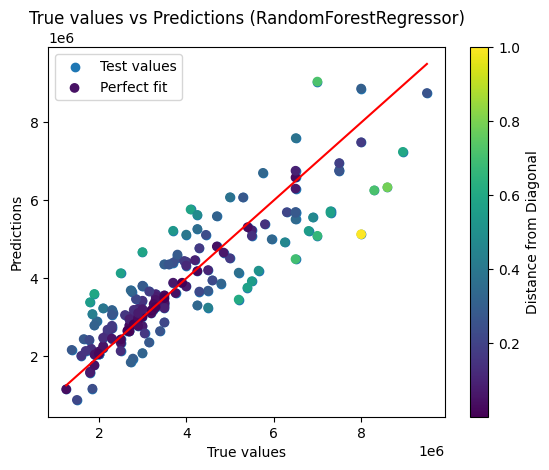

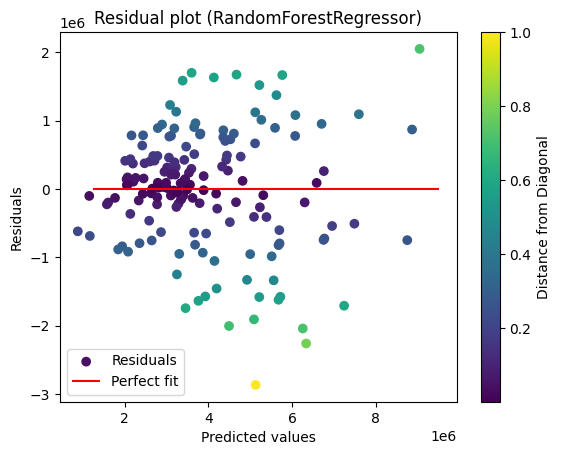

Top 5 worst predictions


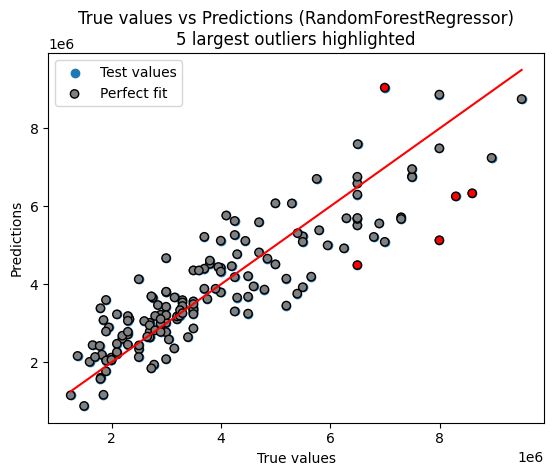

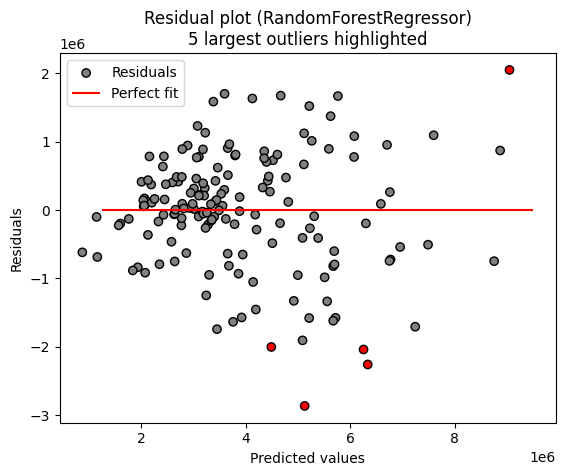

Predicted 5128603.11014856 True 7995000 Residual 2866396.8898514397 Distance 2866396.8898514397


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
60,Bernstorffsvej 98B 2900 Hellerup,102,0,7995000,112,0,3.0,1891.0,1891.0,6,55.725091,12.555232,54932.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


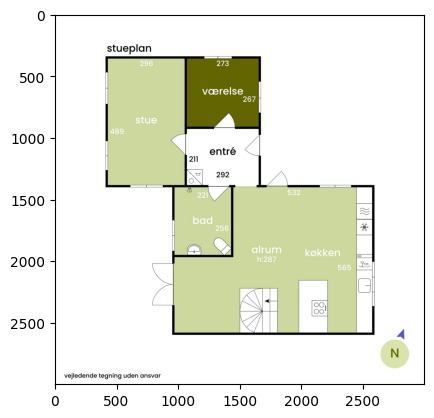

Predicted 6334980.363637858 True 8595000 Residual 2260019.636362142 Distance 2260019.636362142


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
631,Rundholtsvej 56 4. 2 2300 København S,69,0,8595000,125,0,4.0,2014.0,2014.0,0,55.653439,12.565783,44946.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


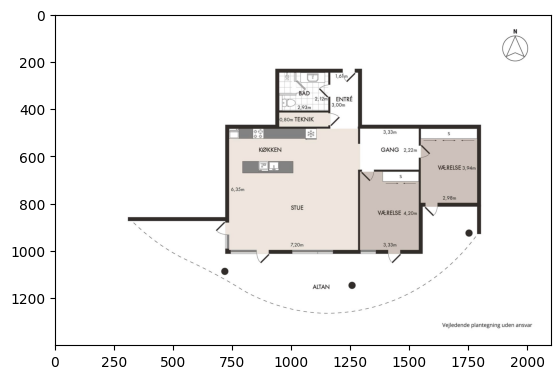

Predicted 9046583.527831327 True 6995000 Residual -2051583.5278313272 Distance 2051583.5278313272


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
55,Bergensgade 5 st. 2100 København Ø,66,0,6995000,178,0,5.0,1905.0,1905.0,6,55.693693,12.586462,55737.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


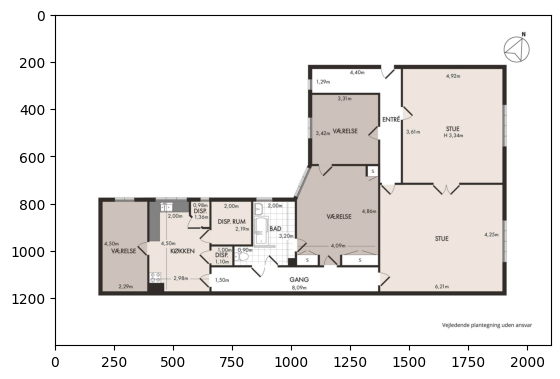

Predicted 6254634.260609893 True 8295000 Residual 2040365.7393901069 Distance 2040365.7393901069


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
879,Øresund Parkvej 19 3. tv 2300 København S,69,0,8295000,126,0,4.0,2005.0,2005.0,4,55.66341,12.630028,44946.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


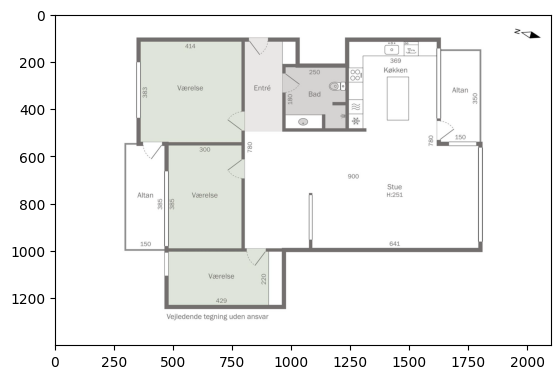

Predicted 4491285.011763489 True 6495000 Residual 2003714.9882365111 Distance 2003714.9882365111


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
409,Kapelvej 1 3. th. 2200 København N,68,0,6495000,83,0,4.0,1891.0,1891.0,4,55.690264,12.554412,51502.5,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


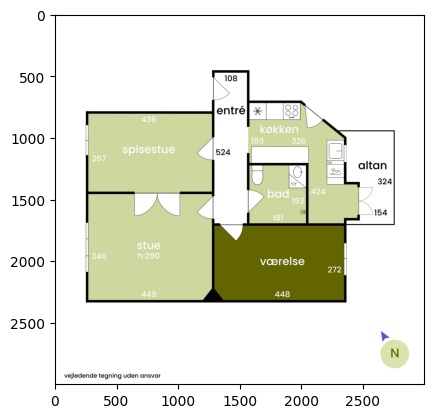

Top 5 best predictions
Predicted 3490628.922532939 True 3495000 Residual 4371.077467061114 Distance 4371.077467061114


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
189,Emil Pipers Vej 41 1. th. 2800 Lyngby,94,0,3495000,84,0,3.0,1935.0,1935.0,7,55.767161,12.499208,37412.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


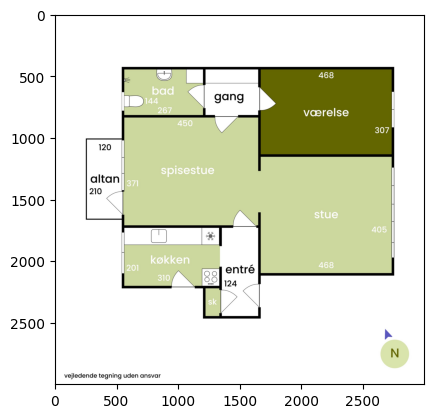

Predicted 2656225.723519216 True 2650000 Residual -6225.723519215826 Distance 6225.723519215826


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
83,Bondehavevej 9 1. tv. 2880 Bagsværd,101,0,2650000,72,0,3.0,1940.0,1940.0,6,55.761656,12.46171,29781.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


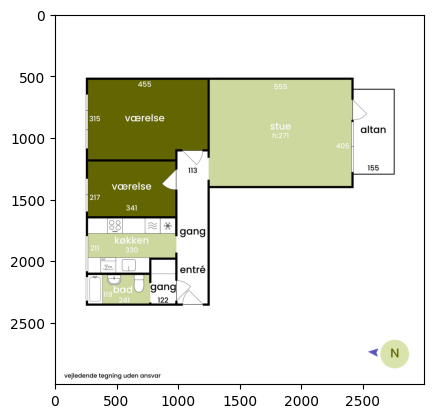

Predicted 3884241.8743745857 True 3900000 Residual 15758.125625414308 Distance 15758.125625414308


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
641,Rævehøjparken 61 2800 Kongens Lyngby,94,0,3900000,88,0,4.0,1981.0,1981.0,4,55.788979,12.533351,37412.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


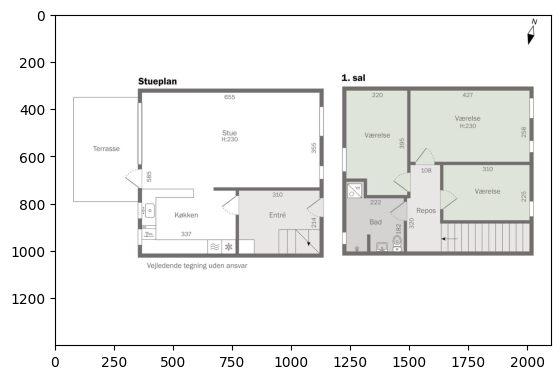

Predicted 3010769.0751216155 True 2995000 Residual -15769.075121615548 Distance 15769.075121615548


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
498,Mariendalsvej 11 1. th 2000 Frederiksberg,65,0,2995000,58,0,2.0,1936.0,1936.0,7,55.688361,12.539058,50502.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


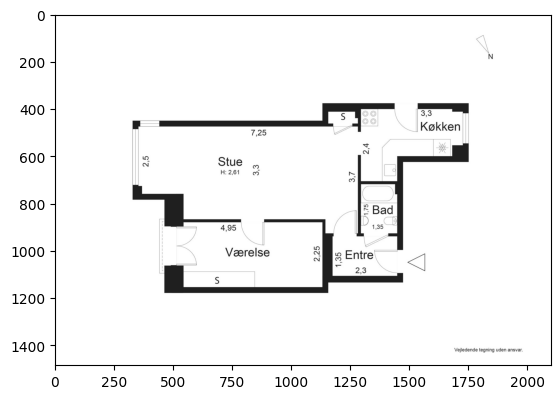

Predicted 3173801.399575954 True 3195000 Residual 21198.600424046163 Distance 21198.600424046163


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
781,Valdemarsgade 1A st.. th. 1665 København V,41,0,3195000,51,0,2.0,1875.0,1875.0,4,55.864483,9.884559,57450.25,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


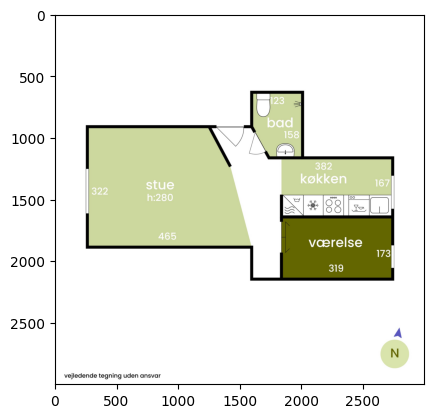

2024-04-18 10:59:40.420809: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 10:59:40.692494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 10:59:40.692663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 10:59:40.695842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 10:59:40.696204: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 14, 14, 1536)      10783535  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 301056)            0         
                                                                 
 dense (Dense)               (None, 512)               154141184 
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

2024-04-18 11:00:24.657876: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-18 11:00:25.250522: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-18 11:00:25.622423: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8/8 [==============================] - 18s 1s/step
Selected layer: dense_2
5/5 [==============================] - 9s 2s/step
Feature importances
size: 0.5910074753536557
postal_avg_sqm_price: 0.14589769573749173
lng: 0.05203888222456567
postal_code: 0.047566060312431435
vision_feature_0: 0.04401912830092651
year_built: 0.04338273560966423
year_rebuilt: 0.027412654924066786
lat: 0.027324192880669382
rooms: 0.011810860207207478
energy_label: 0.009540314449321002
basement_size: 0.0
type: 0.0
R^2: 0.8097817844231748
Mean Absolute Error: 605882.2991659706
Mean Percentage Error: 16.67279548116041
Mean Squared Error: 642291918923.352


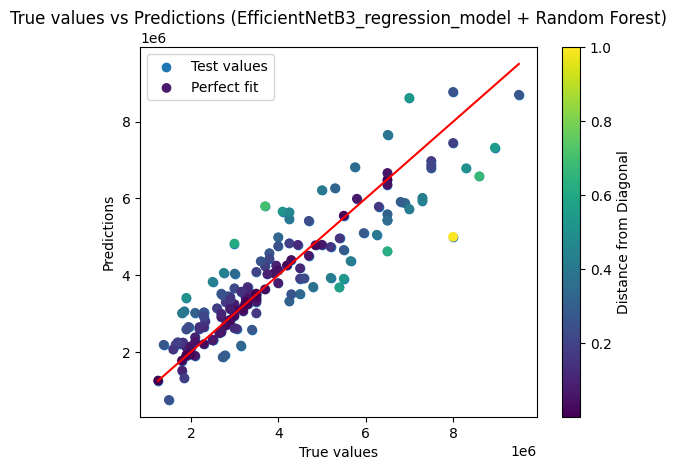

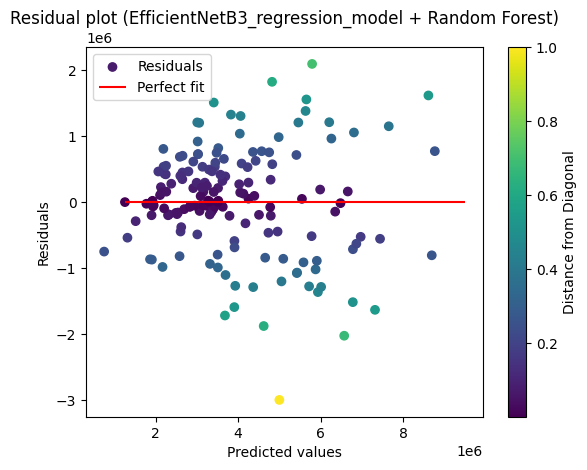

Top 5 worst predictions


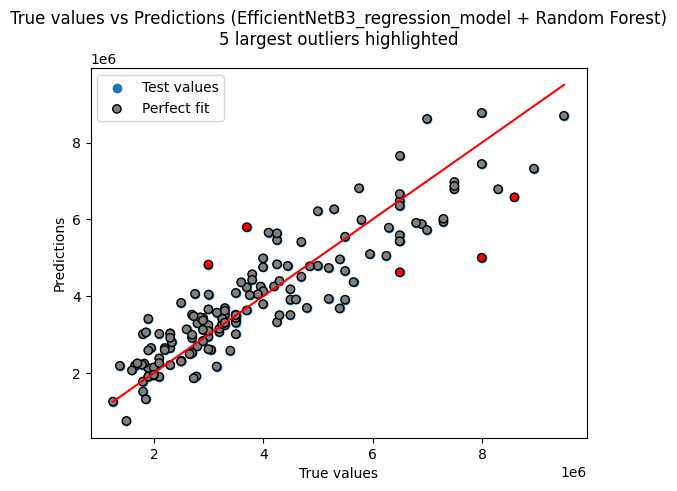

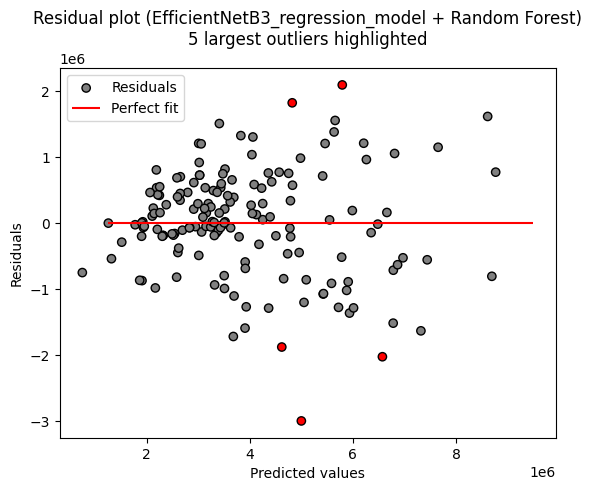

Predicted 4999228.008834632 True 7995000 Residual 2995771.991165368 Distance 2995771.991165368


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
60,Bernstorffsvej 98B 2900 Hellerup,102,0,7995000,112,0,3.0,1891.0,1891.0,6,55.725091,12.555232,54932.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2895260.0


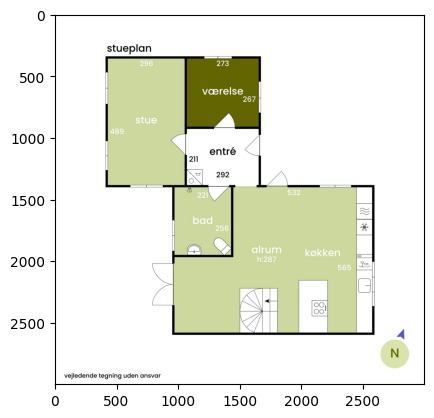

Predicted 5793426.164288415 True 3695000 Residual -2098426.1642884146 Distance 2098426.1642884146


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
416,Kildegårds Plads 3 1. th. 2820 Gentofte,95,0,3695000,122,0,4.0,1932.0,1932.0,9,55.737627,12.538944,35021.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",6194174.0


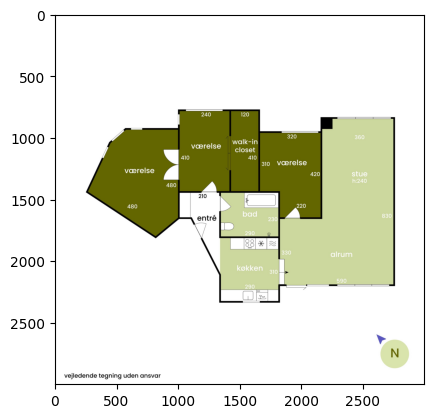

Predicted 6572429.155727256 True 8595000 Residual 2022570.844272744 Distance 2022570.844272744


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
631,Rundholtsvej 56 4. 2 2300 København S,69,0,8595000,125,0,4.0,2014.0,2014.0,0,55.653439,12.565783,44946.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",5229451.5


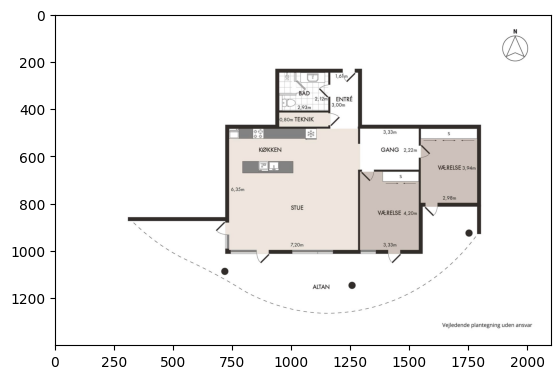

Predicted 4619546.992008965 True 6495000 Residual 1875453.0079910345 Distance 1875453.0079910345


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
409,Kapelvej 1 3. th. 2200 København N,68,0,6495000,83,0,4.0,1891.0,1891.0,4,55.690264,12.554412,51502.5,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3635672.0


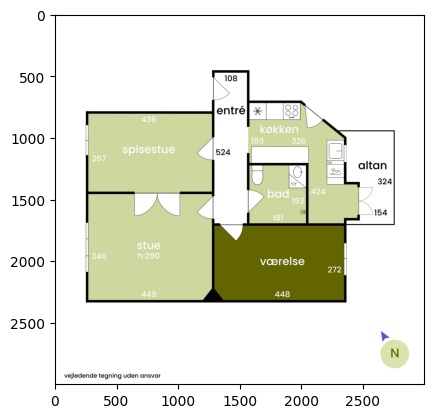

Predicted 4822175.331125617 True 2995000 Residual -1827175.331125617 Distance 1827175.331125617


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
625,Roskildevej 327 2. th 2610 Rødovre,75,0,2995000,104,0,4.0,1938.0,1966.0,7,55.671598,12.463566,33273.25,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4290819.5


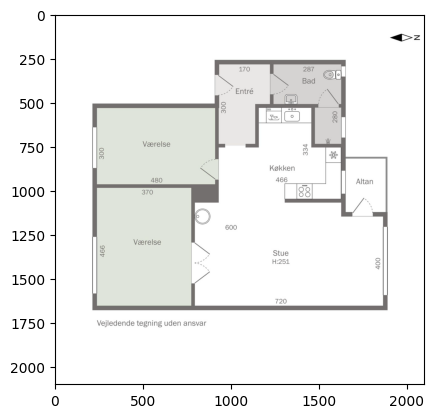

Top 5 best predictions
Predicted 1253321.2858016505 True 1250000 Residual -3321.2858016504906 Distance 3321.2858016504906


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
667,Saven A 1 3. 1 Høje Taastrup 2630 Taastrup,78,0,1250000,35,0,2.0,1974.0,1974.0,4,55.652106,12.278158,24643.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2454249.5


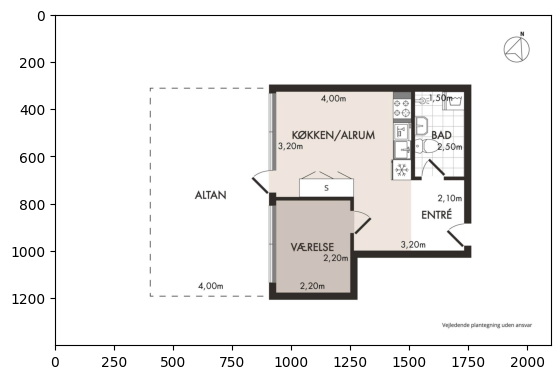

Predicted 3502450.8249339666 True 3495000 Residual -7450.824933966622 Distance 7450.824933966622


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
189,Emil Pipers Vej 41 1. th. 2800 Lyngby,94,0,3495000,84,0,3.0,1935.0,1935.0,7,55.767161,12.499208,37412.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3039352.5


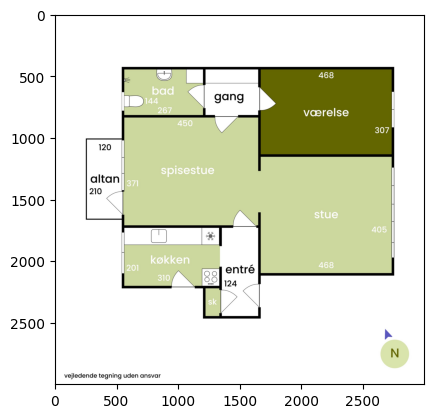

Predicted 1902511.0978692926 True 1895000 Residual -7511.0978692926 Distance 7511.0978692926


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
76,Bobakken 2 3. mf 2720 Vanløse,87,0,1895000,44,0,2.0,1940.0,1940.0,4,55.682834,12.486667,37895.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2675145.5


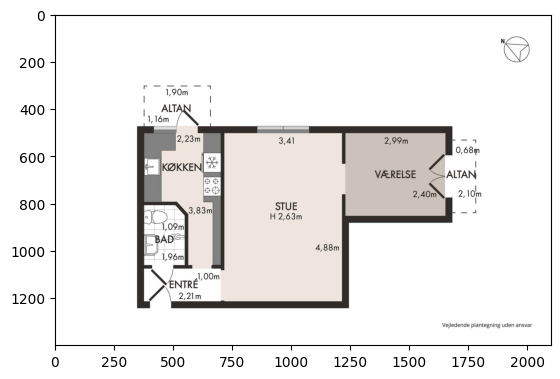

Predicted 3307168.201565303 True 3295000 Residual -12168.201565302908 Distance 12168.201565302908


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
883,Ørnevej 46 1. tv. 2400 København NV,70,0,3295000,70,0,2.0,1925.0,1925.0,6,55.701774,12.529991,40391.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2868986.75


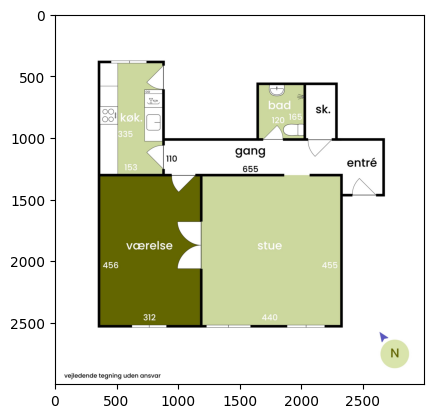

Predicted 6482594.236265915 True 6495000 Residual 12405.763734084554 Distance 12405.763734084554


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan,vision_feature_0
311,Havneholmen 22 2. th 1561 København V,32,0,6495000,106,0,3.0,2009.0,2009.0,4,0.0,4.511256,57450.25,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3734629.75


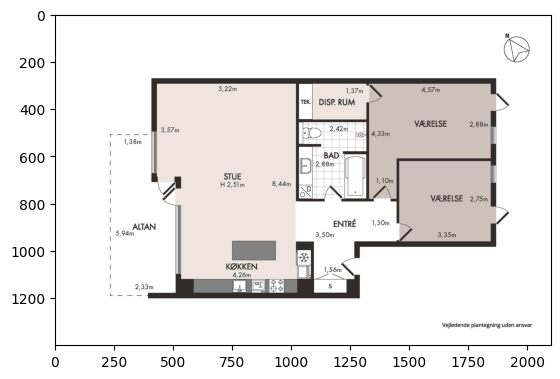

In [8]:
# No model
p = Process(target=random_forest_prediction_with_feature_importance, args=(train1_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, False, False, '', 0, 'RandomForestRegressor'))
p.start()
p.join()

# # Base VGG16 model (very slow)
# p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, False, '', 0, 'VGG16_base_model + Random Forest'))
# p.start()
# p.join()

# Transfer learned model with layer index 0
# p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 'VGG16_regression_model', 0, 'VGG16_regression_model + Random Forest'))
p = Process(target=random_forest_prediction_with_feature_importance, args=(train1_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 'EfficientNetB3_regression_model', 0, 'EfficientNetB3_regression_model + Random Forest'))
p.start()
p.join()

# # Transfer learned model with layer index 5
# p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 'VGG16_regression_model', 5, 'VGG16_regression_model + Random Forest (fine-tuned 5th layer)'))
# p.start()
# p.join()

# # Transfer learned model with layer index 10
# p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 'VGG16_regression_model', 10, 'VGG16_regression_model + Random Forest (fine-tuned 10th layer)'))
# p.start()
# p.join()

Trained on half

In [10]:
# Random Forest results:
# Mean Squared Error: 512261329692.3428
# Mean Absolute Error: 494849.47589098546
# R^2: 0.8482910446601504
#
# longtiude and latitude included
# Mean Squared Error: 501469097615.72327
# Mean Absolute Error: 487198.80503144657
# R^2: 0.8514872223905922

# VGG16_base_model + Random Forest results:
# Mean Squared Error: 466141319888.67926
# Mean Absolute Error: 481770.6289308176
# R^2: 0.8619497342820658
#
# longtiude and latitude included
# Mean Squared Error: 469950913638.3648
# Mean Absolute Error: 472490.1257861635
# R^2: 0.8608215025485069

Trained on full

In [ ]:
# RandomForestRegressor only results:
# Mean Squared Error: 694755456690.2964
# Mean Absolute Error: 538561.7727652465
# R^2: 0.8131223167994861
#
# postal_avg_sqm_price included
# Mean Squared Error: 632492955128.0945
# Mean Absolute Error: 506808.16736285156
# R^2: 0.8298698960090719
#
# longtiude and latitude included
# Mean Squared Error: 591002331892.2445
# Mean Absolute Error: 488819.902676399
# R^2: 0.7932054811526761

# VGG16 transfer learned model results:
# scaled by size = False
# resized, grayscale, threshold = True, False, False    
# Mean Squared Error: 751965058430.7913
# Mean Absolute Error: 510813.1216931217
# R^2: 0.7977338837513761
#
# scaled by size = False
# postal_avg_sqm_price included
# resized, grayscale, threshold = True, False, False    
# Mean Squared Error: 694635955279.4406
# Mean Absolute Error: 477701.0888331941
# R^2: 0.813154460694989
#
# scaled by size = False
# resized, grayscale, threshold = True, False, True
# Mean Squared Error: 495341476468.8406
# Mean Absolute Error: 494275.28985507245
# R^2: 0.8324804537754288
#
# scaled by size = True
# resized, grayscale, threshold = True, False, True
# Mean Squared Error: 610185560589.1305
# Mean Absolute Error: 534254.1304347826
# R^2: 0.7936413301156162
#
# longtiude and latitude included
# scaled by size = True
# resized, grayscale, threshold = True, False, True
# Mean Squared Error: 354794183291.2409
# Mean Absolute Error: 405897.15328467154
# R^2: 0.8758558326011502

# VGG16 base model results:
# Mean Squared Error: 794465376955.7971
# Mean Absolute Error: 658118.0434782609
# R^2: 0.7313197344435582

# VGG16 transfer learned model (fine-tuned 5th layer) results:
# Mean Squared Error: 646471826465.2174
# Mean Absolute Error: 597216.231884058
# R^2: 0.781369676958123

# VGG16 transfer learned model (fine-tuned 10th layer) results:
# Mean Squared Error: 704999438270.2898
# Mean Absolute Error: 554477.8985507246
# R^2: 0.7615762224687322

# EfficientNetB3 transfer learned model results:
# scaled by size = False
# postal_avg_sqm_price included
# resized, grayscale, threshold = True, False, False
# Mean Squared Error: 586631881366.3418
# Mean Absolute Error: 445389.55165692006
# R^2: 0.8422057634443739

# When training on the same data as the vision model was trained on, the feature importance for the 
# vision feature is very high. This is however not the case when training on different data. This is
# due to the fact that the vision model has learned to extract features that are useful for the
# specific task it was trained on. When the model is trained on different data, the features extracted
# by the vision model might not be as useful for the new task.

# Vision Transformers + Random Forrest

In [ ]:
from transformers import AutoImageProcessor, TFViTForImageClassification, ViTForImageClassification
from transformers import pipeline

# Load the image processor
set_cpu()
vit_model_path = "nateraw/vit-base-beans"
model = ViTForImageClassification.from_pretrained(vit_model_path)

In [ ]:
#Image preprocessing
target_height = 224
target_width = 224
resize = True
gray_scale = False
threshhold = True

train_images = preprocess_images(train_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshhold)
valid_images = preprocess_images(valid_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshhold)

image_processor = AutoImageProcessor.from_pretrained(vit_model_path)
train_images = image_processor(train_images, return_tensors="pt")
valid_images = image_processor(valid_images, return_tensors="pt")

In [ ]:
train_image_predictions = model(train_images.pixel_values)

In [ ]:
valid_image_predictions = model(valid_images.pixel_values)

In [ ]:
#get the percentaages 
train_image_predictions = train_image_predictions.logits.softmax(dim=-1)
valid_image_predictions = valid_image_predictions.logits.softmax(dim=-1)

In [ ]:
#Add the predictions to the dataframe, as 6 new columns
for i in range(6):
  train_df[f'vit_prediction_{i}'] = train_image_predictions.detach().numpy()[:, i]
  valid_df[f'vit_prediction_{i}'] = valid_image_predictions.detach().numpy()[:, i]

In [ ]:
display(train_df.head())

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Get features of dataframe 
X_train = train_df.drop(columns=['image_floorplan', 'price'])
X_valid = valid_df.drop(columns=['image_floorplan', 'price'])
y_train = train_df['price']
y_valid = valid_df['price']

# Train model with RandomForestRegressor
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

In [ ]:
#Evaluate the model 
y_valid_pred = forest.predict(X_valid)

#Print all features 
#Get feature importances
feature_importances = forest.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
for i in range(len(sorted_indices)):
  print(f"{X_train.columns[sorted_indices[i]]}: {feature_importances[sorted_indices[i]]}")

print("\n")
plot_regression_stats(y_valid, y_valid_pred)
plot_regression_results('Random Forest Regression with Feature Importance', y_valid, y_valid_pred)

In [ ]:
from transformers import AutoImageProcessor, TFViTForImageClassification, ViTForImageClassification
from transformers import pipeline

def vit_rf(vit_model_path, 
           train_data, valid_data, test_data,
           target_width, target_height,
           resize, gray_scale, threshold):

  #preprocess the images
  image_processor = AutoImageProcessor.from_pretrained(vit_model_path, from_pt=True)
  train_images = image_processor(preprocess_images(train_data, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), return_tensors="pt")
  valid_images = image_processor(preprocess_images(valid_data, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), return_tensors="pt")
  test_images = image_processor(preprocess_images(test_data, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), return_tensors="pt")

  
  #load model 
  model = ViTForImageClassification.from_pretrained(vit_model_path)

  #get the first prediction
  train_image_predictions = model(**train_images).logits
  valid_image_predictions = model(**valid_images).logits
  #Gather X_train and Y_train 
  train_df = train_data.drop(columns=['image_floorplan', 'price'])
  train_df['image_predictions'] = train_image_predictions.detach().numpy().tolist()
  y_train = train_data['price']

  #Gather X_valid and Y_valid
  valid_df = valid_data.drop(columns=['image_floorplan', 'price'])
  valid_df['image_predictions'] = valid_image_predictions.detach().numpy().tolist()
  y_valid = valid_data['price']

  display(train_df.head())
  #Train the model
  #forest = RandomForestRegressor(random_state=0)
  #forest.fit(train_df, y_train)

  return None


vit_model_path = "vit-base-beans"
vit_rf(vit_model_path, 
       train_df, valid_df, test_df, 
       target_width=224, target_height=224, resize=True, gray_scale=False, threshold=True
       )  

# SiFT + Features + MobileNet 

In [ ]:
import joblib
from img_utils import create_bow_representation
from sklearn.ensemble import RandomForestRegressor


def Create_Multi_Model(model_list, input_list, target_list):
    """
    Takes a list of models, and a list of inputs. Run each model on each input, and input that into a new RF. Train the new RF.
    """
    # Create a new dataframe
    new_df = pd.DataFrame()
    for model, input in zip(model_list, input_list):
        model_name = "model_" + str(model_list.index(model))
        predictions = model.predict(input).flatten()
        new_df[model_name] = predictions

    # Train a new RF on the new dataframe
    y_train = target_list
    X_train = new_df
    forest = RandomForestRegressor(random_state=0, n_estimators=1000)
    forest.fit(X_train, y_train)
    # print feature importances
    plot_feature_importance(forest, X_train)
    return forest

In [ ]:
#Load the Models
RF_model = joblib.load('trained_models/forest_model.pkl')
MN_model = load_model('trained_models/MobileNet_Continous.keras')
BoW_model = joblib.load('trained_models/RF_BoW.pkl')
XGB_model = joblib.load('trained_models/xgb_model.pkl')
models_list = [BoW_model, MN_model, RF_model, XGB_model]

In [ ]:
#Load the Inputs for each model 
RF_input = valid_df.drop(columns=['image_floorplan', 'price'])
MN_input = preprocess_images(valid_df, 'image_floorplan', 224, 224, True, False, False)
BoW_input = [x.flatten() for x in create_bow_representation(MN_input)]
inputs_list = [BoW_input, MN_input, RF_input, RF_input]

In [ ]:
#Create the combined model 
combined_model = Create_Multi_Model(models_list, inputs_list, valid_df['price'])

In [ ]:
#Predict the test prices 
RF_test_input = test_df.drop(columns=['image_floorplan', 'price'])
MN_test_input = preprocess_images(test_df, 'image_floorplan', 400, 400, True, True, False)
BoW_test_input = [x.flatten() for x in create_bow_representation(MN_test_input)]

RF_test_output = RF_model.predict(RF_test_input)
MN_test_output = MN_model.predict(MN_test_input).flatten()
BoW_test_output = BoW_model.predict(BoW_test_input)
XGB_test_output = XGB_model.predict(RF_test_input)

combined_test_output = pd.DataFrame({'model_0':BoW_test_output, 'model_1':MN_test_output, 'model_2':RF_test_output, 'model_3':XGB_test_output})

#Predict the test prices
combined_test_predictions = combined_model.predict(combined_test_output[['model_0', 'model_1', 'model_2', 'model_3']])
plot_regression_stats(test_df['price'], combined_test_predictions)
plot_regression_results('Combined Model', test_df['price'], combined_test_predictions)

In [ ]:
# Get the 5 worst predictions 
worst_predictions = test_df.copy()
worst_predictions['predictions'] = combined_test_predictions
worst_predictions['error'] = abs(worst_predictions['price'] - worst_predictions['predictions'])
worst_predictions = worst_predictions.sort_values(by='error', ascending=False)
worst_predictions.head(5)


# Loading From Model.py

In [8]:
set_cpu()

Setting CPU


2024-04-18 10:09:21.460891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 10:09:21.773325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 10:09:21.773408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [9]:
from models import *
from img_utils import *
from utils import *

train_prices = train_df["price"]
train_features = train_df.drop(columns=["image_floorplan", "price", "address"])
train_images_224 = preprocess_images(
    train_df, "image_floorplan", 224, 224, True, False, False
)
train_images_448 = preprocess_images(
    train_df, "image_floorplan", 448, 448, True, False, False
)

# Used to train image models
train1_prices = train1_df["price"]
train1_features = train1_df.drop(columns=["image_floorplan", "price", "address"])
train1_images_224 = preprocess_images(
    train1_df, "image_floorplan", 224, 224, True, False, False
)
train1_images_299 = preprocess_images(
    train1_df, "image_floorplan", 299, 299, True, False, False
)
train1_images_448 = preprocess_images(
    train1_df, "image_floorplan", 448, 448, True, False, False
)

# Used to train ensemble methods
train2_prices = train2_df["price"]
train2_features = train2_df.drop(columns=["image_floorplan", "price", "address"])
train2_images_224 = preprocess_images(
    train2_df, "image_floorplan", 224, 224, True, False, False
)
train2_images_299 = preprocess_images(
    train2_df, "image_floorplan", 299, 299, True, False, False
)
train2_images_448 = preprocess_images(
    train2_df, "image_floorplan", 448, 448, True, False, False
)

valid_prices = valid_df["price"]
valid_features = valid_df.drop(columns=["image_floorplan", "price", "address"])
valid_images_224 = preprocess_images(
    valid_df, "image_floorplan", 224, 224, True, False, False
)
valid_images_299 = preprocess_images(
    valid_df, "image_floorplan", 299, 299, True, False, False
)
valid_images_448 = preprocess_images(
    valid_df, "image_floorplan", 448, 448, True, False, False
)

test_prices = test_df["price"]
test_features = test_df.drop(columns=["image_floorplan", "price", "address"])
test_images_224 = preprocess_images(
    test_df, "image_floorplan", 224, 224, True, False, False
)
test_images_299 = preprocess_images(
    test_df, "image_floorplan", 299, 299, True, False, False
)
test_images_448 = preprocess_images(
    test_df, "image_floorplan", 448, 448, True, False, False
)

/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Features Models

Running RF on Features:


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price
779,72,0,53,0,2.0,1924.0,1924.0,6,55.669858,12.490997,41211.25


R^2: 0.8570405274340132
Mean Absolute Error: 461044.6649515847
Mean Percentage Error: 11.211606560761913
Mean Squared Error: 482717775919.79974


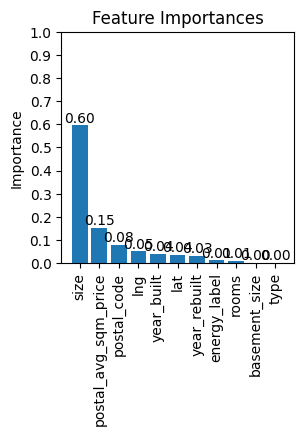

In [23]:
from models import RF
#Set ignore fuiture warning 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
RF_model = RF(train_features, train_prices, test_features, test_prices)

Running RF on Features:


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price
779,72,0,53,0,2.0,1924.0,1924.0,6,55.669858,12.490997,41211.25


R^2: 0.8655609644500155
Mean Absolute Error: 448879.62274985586
Mean Percentage Error: 10.95860355195002
Mean Squared Error: 453947619368.3968


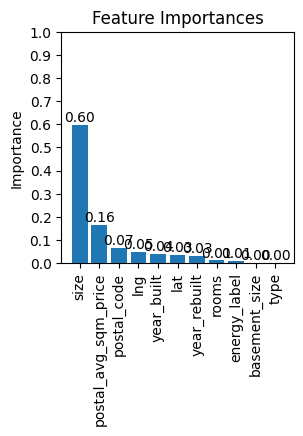

In [24]:
RF_model_full_data = RF(train_features, train_prices, test_features, test_prices)

R^2: 0.8256867960321854
Mean Absolute Error: 504081.4367138365
Mean Percentage Error: 12.308211688888429
Mean Squared Error: 588586965399.9933


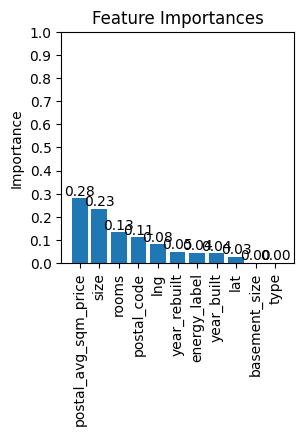

In [25]:
from models import XGB
XGB_model = XGB(train2_features, train2_prices, test_features, test_prices)

### Vision Models 

In [15]:
from tensorflow.keras.applications import MobileNet, MobileNetV3Large, MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import NASNetLarge, NASNetMobile
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications import NASNetMobile

##### CNN - Continoues

In [10]:
from models import CNN_model
MobileNet_Model, MobileNet_fit_hist = CNN_model(VGG16, True, train1_images_224, train1_prices, valid_images_224, valid_prices, use_gpu = True)

2024-04-18 11:01:42.194403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 11:01:42.217659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 11:01:42.217723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 11:01:42.219889: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 11:01:42.220072: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPU
Epoch 1/150


2024-04-18 11:01:44.768201: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-18 11:01:44.843742: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-18 11:01:44.964442: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-18 11:01:46.039186: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-04-18 11:01:53.110541: I externa

8/8 [==============================] - 23s 2s/step - loss: 3772540.0000 - mean_absolute_error: 3771787.5000 - val_loss: 3459828.0000 - val_mean_absolute_error: 3459350.7500
Epoch 2/150
8/8 [==============================] - 1s 164ms/step - loss: 3752805.0000 - mean_absolute_error: 3752386.0000 - val_loss: 3414114.7500 - val_mean_absolute_error: 3413679.7500
Epoch 3/150
8/8 [==============================] - 1s 162ms/step - loss: 3656290.2500 - mean_absolute_error: 3655803.5000 - val_loss: 3225257.5000 - val_mean_absolute_error: 3224705.5000
Epoch 4/150
8/8 [==============================] - 1s 161ms/step - loss: 3317635.7500 - mean_absolute_error: 3317008.7500 - val_loss: 2614332.0000 - val_mean_absolute_error: 2613593.2500
Epoch 5/150
8/8 [==============================] - 1s 161ms/step - loss: 2310832.7500 - mean_absolute_error: 2309999.7500 - val_loss: 1330074.0000 - val_mean_absolute_error: 1329110.3750
Epoch 6/150
8/8 [==============================] - 1s 155ms/step - loss: 149887

In [11]:
eval_model(MobileNet_Model, test_images_224, test_prices)
eval_model(MobileNet_Model, train2_images_224, train2_prices)

5/5 [==============================] - 1s 148ms/step
R^2: 0.335128674702976
Mean Absolute Error: 1142664.5762578617
Mean Percentage Error: 30.882183740615233
Mean Squared Error: 2245008334596.981
Could not plot feature importances for model <keras.src.engine.sequential.Sequential object at 0x7f1360fdce50>
8/8 [==============================] - 7s 1s/step
R^2: 0.30631056451136196
Mean Absolute Error: 1102597.9950396826
Mean Percentage Error: 37.67406649767162
Mean Squared Error: 2182693896153.4395
Could not plot feature importances for model <keras.src.engine.sequential.Sequential object at 0x7f1360fdce50>


: 

In [31]:
EfficientNetV2S_Model, EfficientNetV2S_Model_fit_hist = CNN_model(EfficientNetV2S, True, train1_images_224, train1_prices, valid_images_224, valid_prices)
eval_model(EfficientNetV2S_Model, test_images_224, test_prices)

Epoch 1/150


KeyboardInterrupt: 

In [ ]:
eval_model(EfficientNetV2S_Model[0], test_images_224, test_prices)
#eval_model(EfficientNetV2S_Model, test_images_224, test_prices)

#### N-CNN - Continoues

In [ ]:
from models import N_CNN_model
n = 3
N_CNN_Model = N_CNN_model(MobileNetV3Small, train_images_224, train_prices, valid_images_224, valid_prices, n)

Epoch 1/150
11/11 [==============================] - 9s 367ms/step - loss: 3692511.5000 - mean_absolute_error: 3691835.5000 - val_loss: 3463384.7500 - val_mean_absolute_error: 3463005.2500
Epoch 2/150
11/11 [==============================] - 3s 260ms/step - loss: 3680762.7500 - mean_absolute_error: 3680282.0000 - val_loss: 3431035.2500 - val_mean_absolute_error: 3430362.5000
Epoch 3/150
11/11 [==============================] - 3s 258ms/step - loss: 3600260.5000 - mean_absolute_error: 3599355.5000 - val_loss: 3241853.5000 - val_mean_absolute_error: 3240568.7500
Epoch 4/150
11/11 [==============================] - 3s 249ms/step - loss: 3204568.7500 - mean_absolute_error: 3202890.2500 - val_loss: 2420515.2500 - val_mean_absolute_error: 2418262.7500
Epoch 5/150
11/11 [==============================] - 3s 263ms/step - loss: 1920727.3750 - mean_absolute_error: 1917974.2500 - val_loss: 1256890.2500 - val_mean_absolute_error: 1253516.6250
Epoch 6/150
11/11 [==============================] - 3s

#### ViT (not working)

In [ ]:
from models import ViT_model
ViT_model = ViT_model(train1_images_224, train1_prices, valid_images_224, valid_prices)

 193077248/1218991142 [===>..........................] - ETA: 31s

KeyboardInterrupt: 

#### BoVW (not working)

In [ ]:
from models import BoVW_RF_model
BoVW_RF_model_ = BoVW_RF_model(train1_images_224, train1_prices, valid_images_224, valid_prices)

### Ensemble Methods

##### CNN Pred + Features -> RF

5/5 [==============================] - 1s 141ms/step
Running RF on features:


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_predictions
584,99,0,55,0,2.0,1966.0,1966.0,6,55.719478,12.466065,32687.5,2266564.0


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_predictions
430,97,0,84,0,3.0,1935.0,1935.0,6,55.972009,12.400299,36072.25,2241522.25


Running RF on Features:


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_predictions
584,99,0,55,0,2.0,1966.0,1966.0,6,55.719478,12.466065,32687.5,2266564.0


R^2: 0.8336053227887571
Mean Absolute Error: 506750.94688261417
Mean Percentage Error: 12.318240260049828
Mean Squared Error: 561849222486.6699


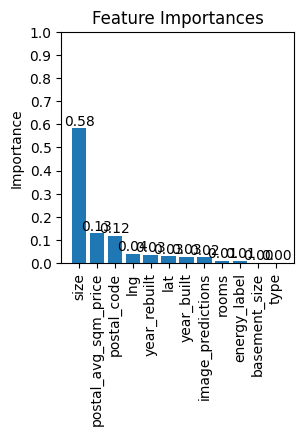

Running RF on Features:


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price
584,99,0,55,0,2.0,1966.0,1966.0,6,55.719478,12.466065,32687.5


R^2: 0.835122779664476
Mean Absolute Error: 497096.57567146025
Mean Percentage Error: 12.060333168104089
Mean Squared Error: 556725368887.0902


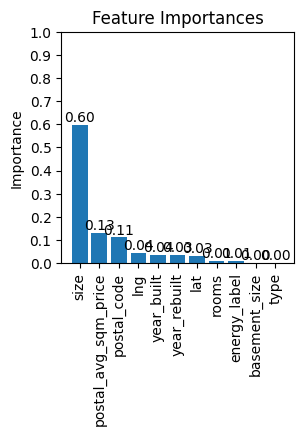

In [26]:
from models import CNN_RF_model 
MN_RF_Model = CNN_RF_model(MobileNet_Model, 
                           train2_images_224, train2_features, train2_prices,
                           test_images_224, test_features, test_prices)

#### CNN Pred + RF(Features) -> RF

5/5 [==============================] - 1s 131ms/step
Running RF on Features:
R^2: 0.8484657322771939
Mean Absolute Error: 474942.6764031234
Mean Percentage Error: 11.310000144173491
Mean Squared Error: 511671478481.6013
Could not plot feature importances for model RandomForestRegressor(max_depth=10)


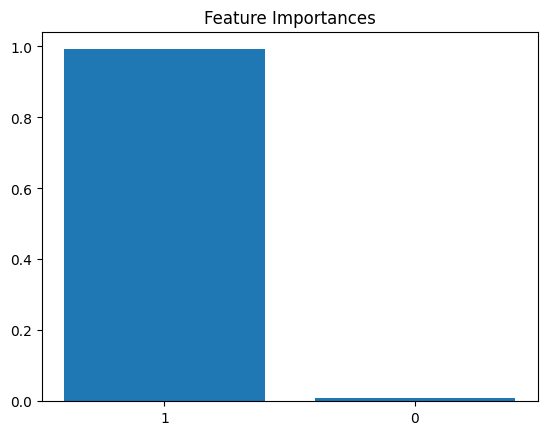

In [27]:
from models import CNN_RF_model_V2
CNN_model = MobileNet_Model
RF_model = RF_model


CNN_RF_Model_v2 = CNN_RF_model_V2(CNN_model, RF_model,
                                  train2_images_224, train2_features, train2_prices,
                                  test_images_224, test_features, test_prices)

#### CNN + AE + Features -> RF 

Traning AutoEncoder
Epoch 1/10
8/8 [==============================] - 6s 607ms/step - loss: 0.1842 - val_loss: 0.1510
Epoch 2/10
8/8 [==============================] - 5s 614ms/step - loss: 0.1173 - val_loss: 0.0683
Epoch 3/10
8/8 [==============================] - 5s 651ms/step - loss: 0.0537 - val_loss: 0.0327
Epoch 4/10
8/8 [==============================] - 5s 575ms/step - loss: 0.0413 - val_loss: 0.0325
Epoch 5/10
8/8 [==============================] - 5s 604ms/step - loss: 0.0423 - val_loss: 0.0313
Epoch 6/10
8/8 [==============================] - 4s 556ms/step - loss: 0.0387 - val_loss: 0.0299
Epoch 7/10
8/8 [==============================] - 5s 571ms/step - loss: 0.0364 - val_loss: 0.0305
Epoch 8/10
8/8 [==============================] - 5s 584ms/step - loss: 0.0345 - val_loss: 0.0279
Epoch 9/10
8/8 [==============================] - 5s 614ms/step - loss: 0.0330 - val_loss: 0.0271
Epoch 10/10
8/8 [==============================] - 5s 583ms/step - loss: 0.0315 - val_loss: 0.0264

,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,reconstruction_error,image_predictions
584,99,0,55,0,2.0,1966.0,1966.0,6,55.719478,12.466065,32687.5,54525.867188,2266564.0


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,reconstruction_error,image_predictions
430,97,0,84,0,3.0,1935.0,1935.0,6,55.972009,12.400299,36072.25,63729.714844,2241522.25


Running RF on Features:


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,reconstruction_error,image_predictions
584,99,0,55,0,2.0,1966.0,1966.0,6,55.719478,12.466065,32687.5,54525.867188,2266564.0


R^2: 0.839130295790407
Mean Absolute Error: 503806.16806695145
Mean Percentage Error: 12.435662118504014
Mean Squared Error: 543193566925.669


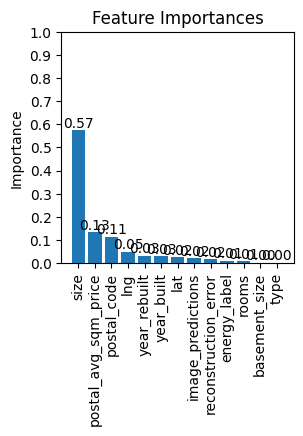

In [28]:
from models import CNN_AE_RF_model
MN_AE_RF_Model = CNN_AE_RF_model(MobileNet_Model, 
                                 train2_images_224, train2_features, train2_prices,
                                 test_images_224, test_features, test_prices)

#### N-CNN + Features -> RF (not working)

In [ ]:
from models import N_CNN_RF_model
#Turn combined features and test_features into a df

N_CNN_RF_Model = N_CNN_RF_model(N_CNN_Model, 
                                 train_images_224, train_features, train_prices,
                                 test_images_224, test_features, test_prices)

2/2 [==============================] - 0s 84ms/step
Running RF on Features:


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_predictions
779,72,0,53,0,2.0,1924.0,1924.0,6,55.669858,12.490997,41211.25,2303669.25


/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
500 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_pa

Params for model {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- reconstruction_error


#### CNN + MLP 

In [29]:
from models import CNN_MLP_model

CNN_MLP_Model = CNN_MLP_model(MobileNetV3Small, 
                              train_images_224, train_features, train_prices,
                              test_images_224, test_features, test_prices)

Epoch 1/250
 6/16 [==========>...................] - ETA: 1s - loss: 3639935.7500 - mean_absolute_error: 3639926.0000

2024-04-18 09:34:15.641968: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


10/16 [=================>............] - ETA: 0s - loss: 3707346.5000 - mean_absolute_error: 3707337.5000

2024-04-18 09:34:16.226950: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


16/16 [==============================] - ETA: 0s - loss: 3690125.5000 - mean_absolute_error: 3690116.0000

ValueError: in user code:

    File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model" is incompatible with the layer: expected shape=(None, 11), found shape=(None, 12)


# Legacy

## CNN Continoues w. House Size Prediction as Feature

In [ ]:
from models import CNN_model_size
from models import CNN_RF_Size_model_V2
from tensorflow.keras.applications import MobileNetV3Large
pretrained = MobileNetV3Small
print(len(train1_images_224))
print(len(train1_features['size']))
print(len(valid_images_224))
print(len(valid_features['size']))
CNN_model_house_size, history_fit = CNN_model_size(pretrained, train1_images_224, train1_features['size'], valid_images_224, valid_features['size'])
CNN_RF_W_size = CNN_RF_Size_model_V2(MN_Model, CNN_model_house_size,
                             train2_images_224, train2_features, train2_prices, 
                             test_images_224, test_features, test_prices)

## CNN Softmax 

In [ ]:
from models import CNN_model_labels_softmax
MN_softmax = CNN_model_labels_softmax(pretrained, num_labels, train1_images_224, train1_labels, valid_images_224, valid_labels)

In [ ]:
from img_utils import label_score_softmax
softmax_predictions = MN_softmax.predict(test_images_448)
label_score_softmax(softmax_predictions, test_labels)

##  CNN Labels

In [ ]:
from models import CNN_model_labels
pretrained = MobileNetV3Small
MN_Model_labels = CNN_model_labels(pretrained,
                                   num_labels, 
                                   train1_images_224, 
                                   train1_labels, valid_images_224, valid_labels)

In [ ]:
from img_utils import label_score 
predicted_labels = MN_Model_labels.predict(test_images_224).argmax(axis=1)
label_score(predicted_labels, test_labels.argmax(axis=1))